## 高维线性回归数据集

In [1]:
# 导入mxnet
import random
import mxnet as mx

# 设置随机种子
random.seed(2)
mx.random.seed(2)

from mxnet import gluon
from mxnet import ndarray as nd
from mxnet import autograd


# 训练数据数量
num_train = 20

# 测试数据数量
num_test = 100

# 输入数据特征维度
num_inputs = 200

# 实际权重
true_w = nd.ones((num_inputs, 1)) * 0.01

# 实际偏置
true_b = 0.05

# 生成数据
X = nd.random_normal(shape=(num_train + num_test, num_inputs))
y = nd.dot(X, true_w) + true_b

# 添加随机噪声
y += 0.01 * nd.random_normal(shape=y.shape)

# 训练数据和测试数据
X_train, X_test = X[:num_train, :], X[num_train:, :]
y_train, y_test = y[:num_train], y[num_train:]

## 定义训练和测试

In [2]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

# 批数据大小
batch_size = 1

# 创建数据集
dataset_train = gluon.data.ArrayDataset(X_train, y_train)

# 读取数据
data_iter = gluon.data.DataLoader(dataset_train, batch_size, shuffle=True)

# 损失函数
square_loss = gluon.loss.L2Loss()

# 测试
def test(net, X, y):
    return square_loss(net(X), y).mean().asscalar()

# 训练
def train(weight_decay):
    # 定义训练的迭代周期
    epochs = 10
    # 定义学习率
    learning_rate = 0.005
    # 定义网络
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    #net.collect_params().initialize(mx.init.Normal(sigma=1))
    # 初始化网络参数
    net.initialize(mx.init.Normal(sigma=1))
    # SGD训练, 使用权重衰减代替L2正则化
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate, 'wd': weight_decay})
    # 训练损失
    train_loss = []
    # 测试损失
    test_loss = []
    for epoch in range(epochs):
        for data, label in data_iter:
            # 记录梯度
            with autograd.record():
                # 计算预测值
                output = net(data)
                # 计算损失
                loss = square_loss(output, label)
            # 反向传播
            loss.backward()
            # 更新权重
            trainer.step(batch_size)
            # 训练损失
            train_loss.append(test(net, X_train, y_train))
            # 测试损失
            test_loss.append(test(net, X_test, y_test))
    # 绘制图像
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train','test'])
    plt.show()
    return ('learned w[:10]:', net[0].weight.data()[:,:10], '\nlearned b:', net[0].bias.data())

## 训练模型并观察过拟合

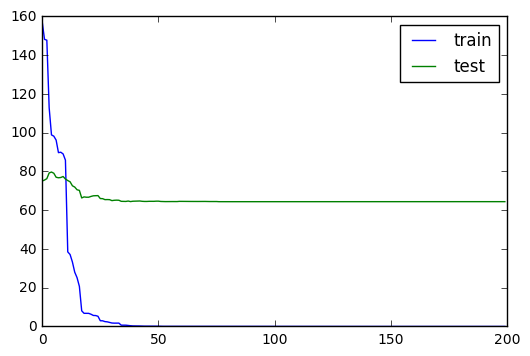

('learned w[:10]:', 
 [[ 1.04817235 -0.02568591  0.86764944  0.29322273  0.01006198 -0.56152564
    0.38436413 -0.3084037  -2.32450151  0.03733355]]
 <NDArray 1x10 @cpu(0)>, '\nlearned b:', 
 [ 0.79914868]
 <NDArray 1 @cpu(0)>)

In [3]:
train(0)

## 使用Gluon的正则化

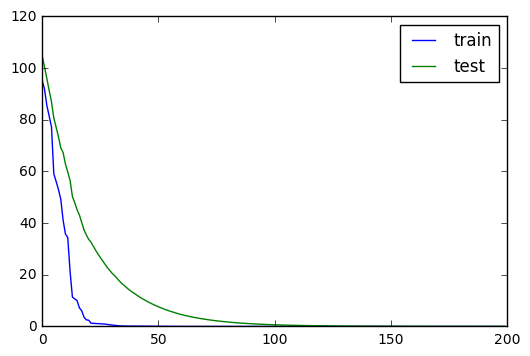

('learned w[:10]:', 
 [[ 0.00107634 -0.00052574  0.00450234 -0.00110544 -0.00683913 -0.00181657
   -0.00530634  0.00512847 -0.00742552 -0.00058494]]
 <NDArray 1x10 @cpu(0)>, '\nlearned b:', 
 [ 0.00449433]
 <NDArray 1 @cpu(0)>)

In [4]:
train(5)

## 可用权重衰减代替L2正则化的原因  

![推导](https://discuss.gluon.ai/uploads/default/optimized/2X/e/e95646511afc71bf614ba6abdb99bd056ee79ea9_1_690x438.png)

注：图片来自Gluon社区。